# **`COVID-19 tweets - Sentiment Analysis`**

---
This notebook is divided to following sections:
1. GOAL
2. Exploratory Data Analysis
3. Data Pre-processing
4. Machine Learning
5. Conclusion


### **1. GOAL**

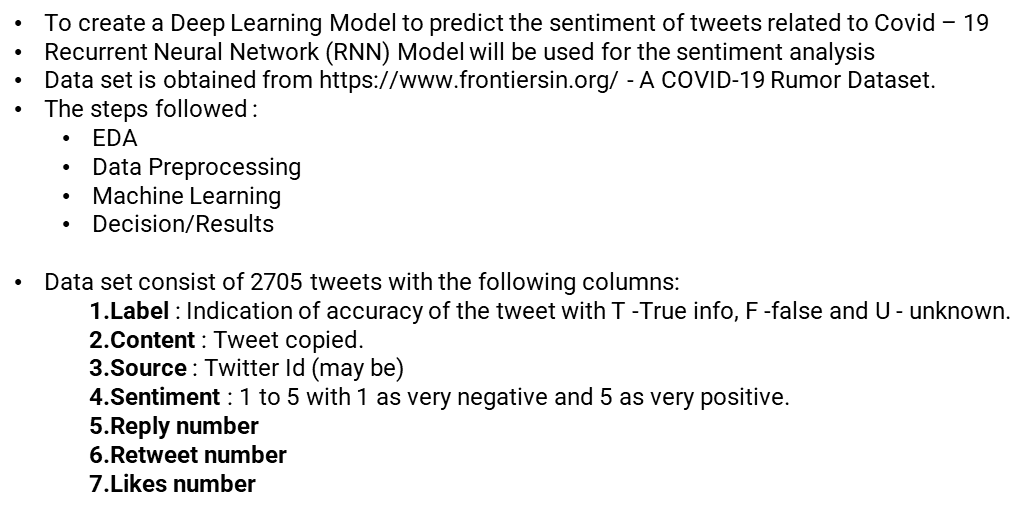

In [1]:
#import libraries

import numpy as np
import pandas as pd

#for plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Data pre-processing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re #Regular Expressions library
import nltk #Natural Language Toolkit
from nltk.stem.porter import PorterStemmer


In [2]:
# Read the data set downloaded from url= 'http://github.com/MickeysClubhouse/COVID-19-rumor-dataset/blob/master/Data/twitter/Twitter.csv'

df=pd.read_csv('./Twitter.csv')

### **2. Exploratory Data Analysis**

In [3]:
#print a sample of the data set
df.head()

,No.,label,content,source,sentiment,reply numbers,retweet numbers,likes numbers
0,1,F,"If you can hold your breath without coughing, ...",850196512341262036,3,2.0,61.0,95.0
1,2,F,A homemade hand sanitizer made with Tito's Vod...,8081445194953918218,3,3.0,41.0,67.0
2,3,F,Gargling with salt water or Vinegar 'eliminate...,1803907737236930232,3,6.0,39.0,73.0
3,4,U,Patients should avoid taking ibuprofen to reli...,1989310298994352163,3,0.0,0.0,0.0
4,5,F,Chinese officials are seeking approval to star...,6967004759672387621,4,0.0,0.0,0.0


In [4]:
# Shape of data set
print ('There are {} rows and {} columns in the data set'.format(df.shape[0], df.shape[1]))


There are 2705 rows and 8 columns in the data set


In [5]:
#name of the columns
df.columns

Index(['No.', 'label', 'content', 'source', 'sentiment', 'reply numbers',
       'retweet numbers', 'likes numbers'],
      dtype='object')

In [6]:
# the column No. is not required. Dropping the column
#Also the column source doesn't make any sense. Hence dropping
df= df.drop(['No.', 'source'], axis=1)

In [7]:
df.head()

,label,content,sentiment,reply numbers,retweet numbers,likes numbers
0,F,"If you can hold your breath without coughing, ...",3,2.0,61.0,95.0
1,F,A homemade hand sanitizer made with Tito's Vod...,3,3.0,41.0,67.0
2,F,Gargling with salt water or Vinegar 'eliminate...,3,6.0,39.0,73.0
3,U,Patients should avoid taking ibuprofen to reli...,3,0.0,0.0,0.0
4,F,Chinese officials are seeking approval to star...,4,0.0,0.0,0.0


In [8]:
#data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2705 entries, 0 to 2704
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   label            2705 non-null   object 
 1   content          2705 non-null   object 
 2   sentiment        2575 non-null   object 
 3   reply numbers    2704 non-null   float64
 4   retweet numbers  2704 non-null   float64
 5   likes numbers    2704 non-null   float64
dtypes: float64(3), object(3)
memory usage: 126.9+ KB


data information shows there are some null rows for column - sentiment

In [9]:
df.describe()

,reply numbers,retweet numbers,likes numbers
count,2704.000000,2704.000000,2704.000000
mean,191.941568,1794.463388,6131.029586
std,1788.104540,10955.502843,43911.441030
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.750000
50%,2.000000,11.000000,20.000000
75%,26.000000,180.000000,333.000000
max,59251.000000,189193.000000,829031.000000


In [10]:
#counts of label data
df['label'].value_counts()

U    1125
T    1040
F     540
Name: label, dtype: int64

In [11]:
#counts of sentiment data
df['sentiment'].value_counts()

3          1246
4           611
2           364
#VALUE!     354
Name: sentiment, dtype: int64

The data set is having only tweets classified as 2 - negative, 3 - neutral and 4 - positive.

There are no data for 1 - very negative and 5 - very positive.

Also 354 tweets are with unknown value #VALUE! and 130 tweets without any value for sentiment

Will seperate the tweets with unknown sentiment for prediction with the model.


In [12]:
df['sentiment'].isnull().value_counts()

False    2575
True      130
Name: sentiment, dtype: int64

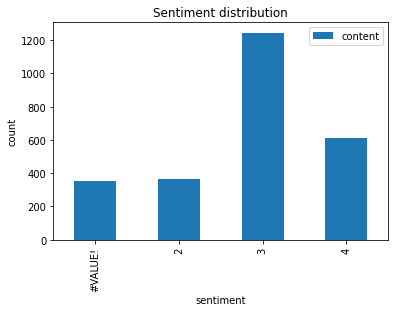

In [13]:
#plotting the sentiment distrubution
sentimentPlot = df.groupby('sentiment').count().plot(kind = 'bar', title = 'Sentiment distribution', ylabel= 'count', y = 'content')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


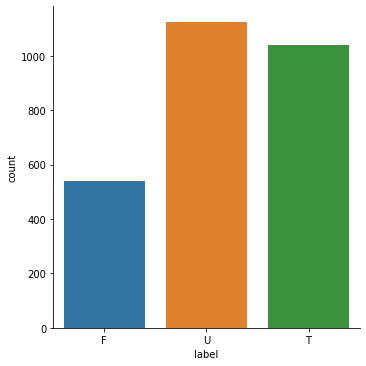

In [14]:
#plotting the accuracy distrubution
# accuracyPlot = df.groupby('label').count().plot(kind = 'bar', title = 'accuracy distribution', ylabel= 'count', y = 'content')
sns.catplot('label', data=df, kind="count")

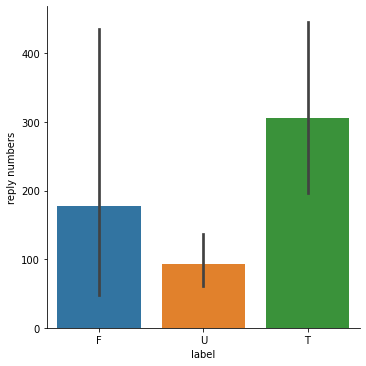

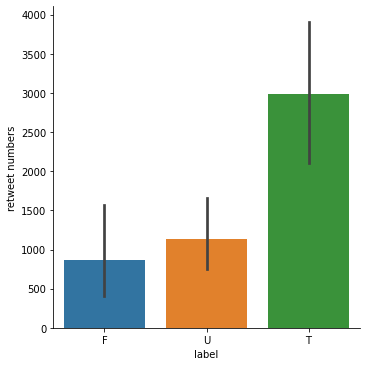

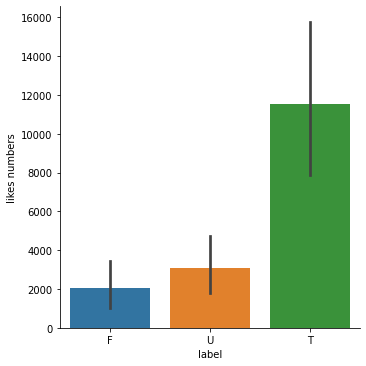

In [15]:
# Reply, retweet and likes received for tweets based on accuracy.

sns.catplot(x='label', y='reply numbers', data=df, kind='bar')
sns.catplot(x='label', y='retweet numbers', data=df, kind='bar')
sns.catplot(x='label', y='likes numbers', data=df, kind='bar')

### **3. Data Pre-processing**

In [16]:
#extracting tweets and sentiments from the data set
dfExtract = df[['content', 'sentiment']]

In [17]:
dfExtract.head()

,content,sentiment
0,"If you can hold your breath without coughing, ...",3
1,A homemade hand sanitizer made with Tito's Vod...,3
2,Gargling with salt water or Vinegar 'eliminate...,3
3,Patients should avoid taking ibuprofen to reli...,3
4,Chinese officials are seeking approval to star...,4


In [18]:
# Making all letters to lowercase
dfExtract['content'] = dfExtract['content'].str.lower()

#Sample after converting to lowercase
dfExtract['content'].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    if you can hold your breath without coughing, ...
1    a homemade hand sanitizer made with tito's vod...
2    gargling with salt water or vinegar 'eliminate...
3    patients should avoid taking ibuprofen to reli...
4    chinese officials are seeking approval to star...
Name: content, dtype: object

#### Cleaning and removing the stopwords

In [19]:
#downloading the stopwords from nltk
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
#creating list of stopwords as sw
sw = nltk.corpus.stopwords.words('english')

#printing the downloaded stopwords list
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [21]:
#removing stopwords from the data

dfExtract['content'] = dfExtract['content'].apply(lambda x: " ".join([w for w in x.split() if w not in sw]))

#Sample after removal of stopwords
dfExtract['content']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0       hold breath without coughing, discomfort, stif...
1       homemade hand sanitizer made tito's vodka used...
2       gargling salt water vinegar 'eliminate' covid-...
3       patients avoid taking ibuprofen relieve pain f...
4       chinese officials seeking approval start mass ...
                              ...                        
2700            telecommunications services country crash
2701    gov. steve sisolak's activation guard week mea...
2702                             officer died coronavirus
2703    national guard mobilized anything else.call mi...
2704    thank leadership mayor lucas! brother also wor...
Name: content, Length: 2705, dtype: object

#### Removing URL's

In [22]:
#list of the url in the tweets
url_list = re.findall(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', str(dfExtract['content']))
url_list


[]

In [23]:
#random tweets which contain URLs (as the previous code to print list of URL containing tweets is not working)
for x in [202, 585, 602, 603, 612]:
  print(dfExtract['content'][x])

interest safety, decided temporarily close us stores public, effective march 18. we'll remain available http://ikea-usa.com continue offer click collect many stores
chinese propaganda machine casting blame united states coronavirus, fp's beijingpalmer writes.https://buff.ly/32kw7ty
miami officials looking postpone ultra music festival amid growing concerns coronavirus https://bit.ly/2voy7ix
today's washingtonpost tiktok features nifty way help avoid exposure coronavirus https://vm.tiktok.com/gy29hh/
in: trump visit cdc initial trip cancelled http://hill.cm/wxdnfif


In [24]:
#removing URL's from the data using sub() from Regular Expression library 
def cleaning_URLs(data):
    return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', data)
dfExtract['content'] = dfExtract['content'].apply(lambda x: cleaning_URLs(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [25]:
#cross checking the tweets for successful removal of URLs
for x in [202, 585, 602, 603, 612]:
  print(dfExtract['content'][x])

interest safety, decided temporarily close us stores public, effective march 18. we'll remain available  continue offer click collect many stores
chinese propaganda machine casting blame united states coronavirus, fp's beijingpalmer writes.
miami officials looking postpone ultra music festival amid growing concerns coronavirus 
today's washingtonpost tiktok features nifty way help avoid exposure coronavirus 
in: trump visit cdc initial trip cancelled 


#### Removing the punctuations

In [26]:
# printing the string punctuations
punc = (string.punctuation)
print(punc)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [27]:
#removing punctuations from the data using string translate method

dfExtract['content'] = dfExtract['content'].apply(lambda x: x.translate(x.maketrans('', '', punc)))

#Sample after removal of punctuations
dfExtract['content']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0       hold breath without coughing discomfort stiffn...
1       homemade hand sanitizer made titos vodka used ...
2       gargling salt water vinegar eliminate covid19 ...
3       patients avoid taking ibuprofen relieve pain f...
4       chinese officials seeking approval start mass ...
                              ...                        
2700            telecommunications services country crash
2701    gov steve sisolaks activation guard week means...
2702                             officer died coronavirus
2703    national guard mobilized anything elsecall mil...
2704    thank leadership mayor lucas brother also work...
Name: content, Length: 2705, dtype: object

#### Removing numbers from the data

In [28]:
#Checking the data for any numbers in it
number_list = [i for i in dfExtract['content'].str.split()
                 if any(j.isdigit() for j in i)]

#sample list of tweets which contain numbers
print(number_list[:5])

[['chinese', 'officials', 'seeking', 'approval', 'start', 'mass', 'killing', '20000', 'people', 'order', 'stop', 'spread', 'new', 'coronavirus'], ['trump', 'administration', 'fired', 'us', 'pandemic', 'response', 'team', '2018', 'cut', 'costs'], ['white', 'house', 'sent', 'text', 'messages', 'midmarch', '2020', 'informing', 'people', 'qwertyu', 'mandatory', 'quarantine', 'us', 'would', 'start', 'within', '48', 'hours'], ['major', 'disease', 'outbreak', 'occurred', 'every', 'election', 'year', 'since', '2004'], ['selfdescribed', 'psychic', 'sylvia', 'browne', 'predicted', '2020', 'outbreak', 'new', 'coronavirus']]


In [29]:
#the number of tweets which contain digits are
len(number_list)

658

In [30]:
#removing numbers from the data using sub() from Regular Expression library 

dfExtract['content'] = dfExtract['content'].apply(lambda x: re.sub('[0-9]+', '', x))

#Sample after removing numbers
dfExtract['content']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0       hold breath without coughing discomfort stiffn...
1       homemade hand sanitizer made titos vodka used ...
2       gargling salt water vinegar eliminate covid co...
3       patients avoid taking ibuprofen relieve pain f...
4       chinese officials seeking approval start mass ...
                              ...                        
2700            telecommunications services country crash
2701    gov steve sisolaks activation guard week means...
2702                             officer died coronavirus
2703    national guard mobilized anything elsecall mil...
2704    thank leadership mayor lucas brother also work...
Name: content, Length: 2705, dtype: object

In [31]:
#cross checking the numbers are removed properly
number_list = [i for i in dfExtract['content'].str.split()
                 if any(j.isdigit() for j in i)]

len(number_list)

0

#### Tweet words with Wordcloud

In [32]:
dfExtract['content']

0       hold breath without coughing discomfort stiffn...
1       homemade hand sanitizer made titos vodka used ...
2       gargling salt water vinegar eliminate covid co...
3       patients avoid taking ibuprofen relieve pain f...
4       chinese officials seeking approval start mass ...
                              ...                        
2700            telecommunications services country crash
2701    gov steve sisolaks activation guard week means...
2702                             officer died coronavirus
2703    national guard mobilized anything elsecall mil...
2704    thank leadership mayor lucas brother also work...
Name: content, Length: 2705, dtype: object

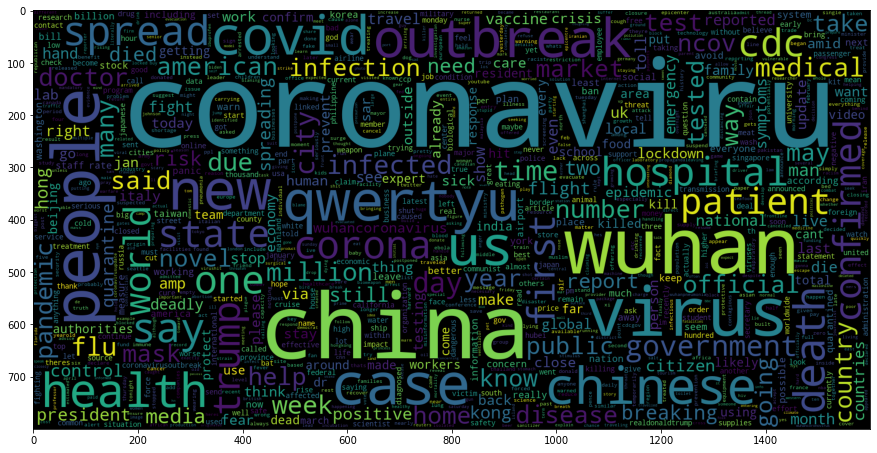

In [33]:
all_words = dfExtract['content']
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(all_words))
plt.imshow(wc)

#### Tokenization

In [34]:
# #tokenizing the tweets
# dfExtract['content']= dfExtract['content'].apply(lambda x: x.split())

# #data after tokenizing
# dfExtract['content']

#### Stemming

In [35]:
# #Stemming is done to reduce the words to their root or stems
# #stemmer is the instance of the previously imported Class from NLTP
# stemmer = PorterStemmer()

# # applying stemmer for tokenized data
# dfExtract['content'] = dfExtract['content'].apply(lambda x: [stemmer.stem(i) for i in x])

# #Data after stemming
# dfExtract['content']

#### Lemmatizing

In [36]:
# #will further reduce the word to its root word based on meaning
# #importing lemmatizing Class
# from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')

# #creating an instance of the class
# lem = WordNetLemmatizer()

# #applying lemmatizer
# dfExtract['content']=dfExtract['content'].apply(lambda x: [lem.lemmatize(i) for i in x])


In [37]:
#dataframe after data processing
dfExtract

,content,sentiment
0,hold breath without coughing discomfort stiffn...,3
1,homemade hand sanitizer made titos vodka used ...,3
2,gargling salt water vinegar eliminate covid co...,3
3,patients avoid taking ibuprofen relieve pain f...,3
4,chinese officials seeking approval start mass ...,4
...,...,...
2700,telecommunications services country crash,3
2701,gov steve sisolaks activation guard week means...,3
2702,officer died coronavirus,2
2703,national guard mobilized anything elsecall mil...,3


#### Feature Extraction

In [38]:
#data frame for test/train of model (data frame with known sentiment value)
dfFinal = dfExtract[dfExtract['sentiment'].isin(['1', '2', '3', '4', '5'])]
dfFinal

,content,sentiment
0,hold breath without coughing discomfort stiffn...,3
1,homemade hand sanitizer made titos vodka used ...,3
2,gargling salt water vinegar eliminate covid co...,3
3,patients avoid taking ibuprofen relieve pain f...,3
4,chinese officials seeking approval start mass ...,4
...,...,...
2699,urses died itu department,2
2700,telecommunications services country crash,3
2701,gov steve sisolaks activation guard week means...,3
2702,officer died coronavirus,2


In [39]:
#data frame for prediction of unknown sentiment (after model training)
dfPredict = dfExtract[~dfExtract['sentiment'].isin(['1', '2', '3', '4', '5'])]
dfPredict

,content,sentiment
28,numbers contagion start go down system italy c...,#VALUE!
45,google helping develop website going quickly d...,#VALUE!
46,serious excellent advice japanese doctors trea...,#VALUE!
52,symptoms first infect throat sore throat last...,#VALUE!
54,serious excellent advice japanese doctors trea...,#VALUE!
...,...,...
2479,best guess billgates responsible engineering a...,#VALUE!
2481,maddowblog maddow rachel canadian daughter tea...,NaN
2482,charles cdc grossly incompetent irresponsible ...,#VALUE!
2483,corona virus going severely impact global manu...,#VALUE!


### **4. Machine Learning**

In [40]:
# Importing libraries for machine learning

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [41]:
#tokenizer to convert the sentence to list of words. num_words is the number of frequent words to keep. Above that less frequent words will be ignored.
max_vocab = 5000
tokenizer = Tokenizer(num_words=max_vocab, split=' ')

# fit_on_texts will calculate the frequency of words and create index for each separate words. Most frequent word is assigned 1
tokenizer.fit_on_texts(dfExtract['content'].values)

#texts_to_sequences will create sequence of integers for each sentence (based on earlier created index)
X = tokenizer.texts_to_sequences(dfFinal['content'].values)

#pad_sequences to make all sequences into equal length
X = pad_sequences(X)
X.shape

(2221, 31)

In [42]:
# creating the RNN model
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(input_dim=max_vocab, output_dim=embed_dim,input_length = X.shape[1]))
model.add(LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 128)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 3)                 591       
Total params: 895,391
Trainable params: 895,391
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
#get_dummies to do one-hot encoding
Y = pd.get_dummies(dfFinal['sentiment']).values

#split data. 2/3 for training and 1/3 for testing.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)

#test and train data set size:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1488, 31) (1488, 3)
(733, 31) (733, 3)


In [44]:
# label after one hot encoding:
Y_train

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [45]:
#train the model with a batch size of 30 rows.
batch_size = 23
model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size, verbose = 2)

Epoch 1/3
65/65 - 39s - loss: 1.0045 - accuracy: 0.5497
Epoch 2/3
65/65 - 12s - loss: 0.9180 - accuracy: 0.5753
Epoch 3/3
65/65 - 12s - loss: 0.5811 - accuracy: 0.7883


### **5. Decision/Results**

In [46]:
#testing the trained model and measuring score & accuracy
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

32/32 - 2s - loss: 1.1307 - accuracy: 0.5034
score: 1.13
acc: 0.50


In [47]:
#encoding for the prediction dataset
X_Pred = tokenizer.texts_to_sequences(dfPredict['content'].values)
X_Pred = pad_sequences(X_Pred,  maxlen=X.shape[1])

In [48]:
#predicted data
result = model.predict(X_Pred, verbose = 2, batch_size = 1)


484/484 - 5s


In [49]:
#sorting the result (selecting the maximum probability)
result = pd.DataFrame(result)
result['sentiment'] = result.idxmax(axis=1)
result

,0,1,2,sentiment
0,0.743476,0.276727,0.478302,0
1,0.306711,0.593024,0.574326,1
2,0.529942,0.218024,0.755392,2
3,0.149142,0.892968,0.330342,1
4,0.538729,0.136284,0.807884,2
...,...,...,...,...
479,0.345315,0.616260,0.503284,1
480,0.243985,0.881397,0.249233,1
481,0.716808,0.417851,0.400640,0
482,0.527532,0.674366,0.324766,1


In [50]:
# decoding the data
result['sentiment'] = result['sentiment'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})
result = result.drop([0,1,2], axis =1)

In [51]:
# predicted sentiment for the tweets
result['tweet'] = dfPredict['content'].values
result

,sentiment,tweet
0,Negative,numbers contagion start go down system italy c...
1,Neutral,google helping develop website going quickly d...
2,Positive,serious excellent advice japanese doctors trea...
3,Neutral,symptoms first infect throat sore throat last...
4,Positive,serious excellent advice japanese doctors trea...
...,...,...
479,Neutral,best guess billgates responsible engineering a...
480,Neutral,maddowblog maddow rachel canadian daughter tea...
481,Negative,charles cdc grossly incompetent irresponsible ...
482,Neutral,corona virus going severely impact global manu...
